## Treino de um modelo de classificação para prever doenças cardíacas (HeartDisease) usando o dataset UCI Heart Disease. Ele compara cinco algoritmos (Regressão Logística, KNN, Árvore de Decisão, Naive Bayes, e SVM) em diferentes cenários (dados originais, padronizados, e normalizados), otimiza hiperparâmetros, seleciona o melhor modelo, e o salva como BEST_model.pkl

## Preparação do ambiente e importação das bibliotecas

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Verify scikit-learn version
import sklearn
print("scikit-learn version:", sklearn.__version__)

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

scikit-learn version: 1.6.1


## Carga e análise do dataset inicial

### Contém 918 registros com 12 colunas: Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease (target, 0 ou 1)

In [ ]:
url = "https://raw.githubusercontent.com/FernandoMBresolin/Heart_Atack_ML/refs/heads/main/heart.csv"
dataset = pd.read_csv(url, delimiter=',')
print("Primeiras linhas do dataset original:\n", dataset.head())
print("\nValores ausentes no dataset original:\n", dataset.isnull().sum())
print("\nDistribuição das classes no dataset original:\n", dataset['HeartDisease'].value_counts(normalize=True))

Primeiras linhas do dataset original:
    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Valores ausentes no dataset original:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingE

## Filtragem de valores zerados

### Registros com Cholesterol == 0 ou RestingBP == 0 são removidos, pois são considerados outliers fisiologicamente improváveis.


In [ ]:
original_size = len(dataset)
dataset = dataset[(dataset['Cholesterol'] != 0) & (dataset['RestingBP'] != 0)]
filtered_size = len(dataset)
patients_removed = original_size - filtered_size
print(f"\nNúmero de pacientes removidos (Cholesterol=0 ou RestingBP=0): {patients_removed}")
print(f"Tamanho do dataset original: {original_size}")
print(f"Tamanho do dataset filtrado: {filtered_size}")


Número de pacientes removidos (Cholesterol=0 ou RestingBP=0): 172
Tamanho do dataset original: 918
Tamanho do dataset filtrado: 746


## Checagem do balanceamento

In [ ]:
print("\nDistribuição das classes no dataset filtrado:\n", dataset['HeartDisease'].value_counts(normalize=True))


Distribuição das classes no dataset filtrado:
 HeartDisease
0    0.522788
1    0.477212
Name: proportion, dtype: float64


## Impressão de intervalos e categorias para referência com o dataset filtrado

### Os intervalos e categorias são usados como referência no schema.py para validação na API, garantindo que os dados enviados estejam dentro dos limites esperados

In [ ]:
numerical_ranges = {
    'Age': (dataset['Age'].min(), dataset['Age'].max()),
    'RestingBP': (dataset['RestingBP'].min(), dataset['RestingBP'].max()),
    'Cholesterol': (dataset['Cholesterol'].min(), dataset['Cholesterol'].max()),
    'FastingBS': (dataset['FastingBS'].min(), dataset['FastingBS'].max()),
    'MaxHR': (dataset['MaxHR'].min(), dataset['MaxHR'].max()),
    'Oldpeak': (dataset['Oldpeak'].min(), dataset['Oldpeak'].max())
}

categorical_values = {
    'Sex': dataset['Sex'].unique().tolist(),
    'ChestPainType': dataset['ChestPainType'].unique().tolist(),
    'RestingECG': dataset['RestingECG'].unique().tolist(),
    'ExerciseAngina': dataset['ExerciseAngina'].unique().tolist(),
    'ST_Slope': dataset['ST_Slope'].unique().tolist()
}

print("\nIntervalos numéricos para validação (após filtragem):")
for col, (min_val, max_val) in numerical_ranges.items():
    print(f"{col}: [{min_val}, {max_val}]")
print("\nCategorias válidas (após filtragem):")
for col, values in categorical_values.items():
    print(f"{col}: {values}")


Intervalos numéricos para validação (após filtragem):
Age: [28, 77]
RestingBP: [92, 200]
Cholesterol: [85, 603]
FastingBS: [0, 1]
MaxHR: [69, 202]
Oldpeak: [-0.1, 6.2]

Categorias válidas (após filtragem):
Sex: ['M', 'F']
ChestPainType: ['ATA', 'NAP', 'ASY', 'TA']
RestingECG: ['Normal', 'ST', 'LVH']
ExerciseAngina: ['N', 'Y']
ST_Slope: ['Up', 'Flat', 'Down']


## PRE PROCESSAMENTO DE DADOS



*   Colunas Categóricas: Codificadas com OneHotEncoder (drop='first') para evitar multicolinearidade, gerando variáveis dummy (ex.: Sex_M, ChestPainType_ATA, etc.)

*   Colunas Numéricas: Mantidas como estão (passthrough) no cenário original, ou escalonadas com StandardScaler ou MinMaxScaler em outros cenários

*   ColumnTransformer: Combina a codificação categórica e o tratamento numérico em um único pipeline


In [ ]:
# Definir colunas categóricas e numéricas
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = [col for col in dataset.columns if col not in categorical_cols + ['HeartDisease']]

# Criar o preprocessor com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols),  # OneHotEncoder para categóricas
        ('num', 'passthrough', numerical_cols)  # Manter numéricas sem alteração
    ])

# Aplicar o preprocessor ao dataset
X = dataset.drop('HeartDisease', axis=1)
y = dataset['HeartDisease']

In [ ]:
# Visualizar dataset transformado
X_transformed = preprocessor.fit_transform(X)
transformed_columns = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns)
print("\nDataset após pré-processamento:")
print(X_transformed_df.head())
print("\nColunas após pré-processamento:")
print(transformed_columns)


Dataset após pré-processamento:
   cat__Sex_M  cat__ChestPainType_ATA  cat__ChestPainType_NAP  \
0         1.0                     1.0                     0.0   
1         0.0                     0.0                     1.0   
2         1.0                     1.0                     0.0   
3         0.0                     0.0                     0.0   
4         1.0                     0.0                     1.0   

   cat__ChestPainType_TA  cat__RestingECG_Normal  cat__RestingECG_ST  \
0                    0.0                     1.0                 0.0   
1                    0.0                     1.0                 0.0   
2                    0.0                     0.0                 1.0   
3                    0.0                     1.0                 0.0   
4                    0.0                     1.0                 0.0   

   cat__ExerciseAngina_Y  cat__ST_Slope_Flat  cat__ST_Slope_Up  num__Age  \
0                    0.0                 0.0               1.0     

## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
# Separação em conjuntos de treino e teste
test_size = 0.20  # tamanho do conjunto de teste
seed = 7  # semente aleatória
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    stratify=y)  # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Avaliação com dados originais, padronizados e normalizados


Acurácias da validação cruzada (dados originais, padronizados e normalizados):
LR-orig: 0.861 (0.026)
LR-padr: 0.862 (0.022)
LR-norm: 0.861 (0.022)
KNN-orig: 0.660 (0.071)
KNN-padr: 0.859 (0.023)
KNN-norm: 0.842 (0.030)
CART-orig: 0.769 (0.053)
CART-padr: 0.775 (0.036)
CART-norm: 0.774 (0.040)
NB-orig: 0.859 (0.026)
NB-padr: 0.859 (0.026)
NB-norm: 0.859 (0.026)
SVM-orig: 0.680 (0.030)
SVM-padr: 0.856 (0.027)
SVM-norm: 0.864 (0.036)


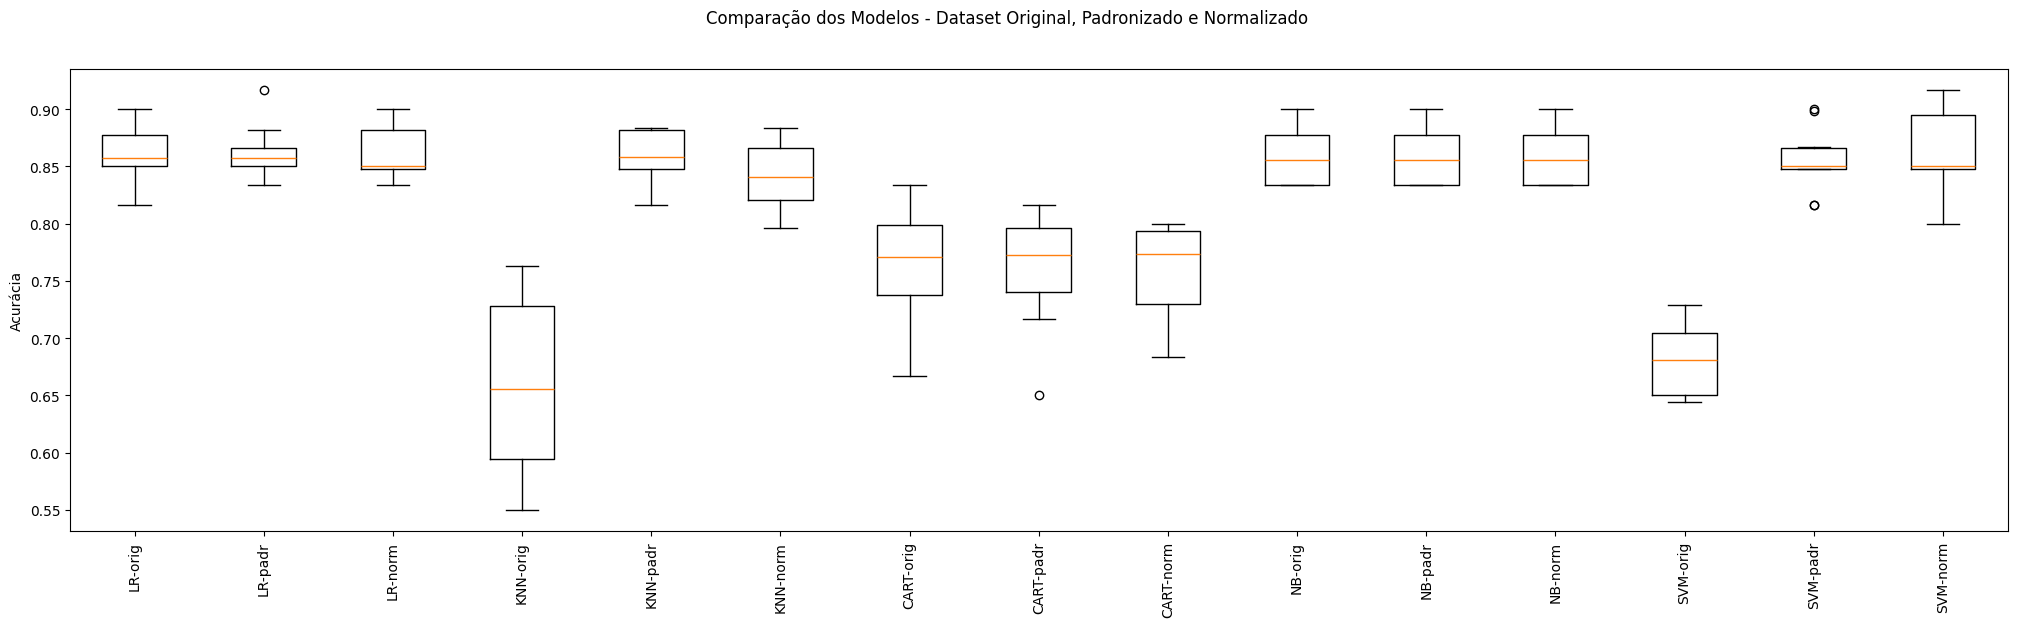

In [ ]:
np.random.seed(7)

# Lista de modelos
models = [
    ('LR', LogisticRegression(max_iter=200)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC())
]

# Pipelines para cada cenário
pipelines = []
all_results = []
all_names = []
all_pipelines = []

# Transformações
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando pipelines
for name, model in models:
    pipelines.append((f'{name}-orig', Pipeline([('preprocessor', preprocessor), ('model', model)])))
    pipelines.append((f'{name}-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, ('model', model)])))
    pipelines.append((f'{name}-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, ('model', model)])))

# Executando e avaliando os pipelines
print("\nAcurácias da validação cruzada (dados originais, padronizados e normalizados):")
for name, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
    all_results.append(cv_results.mean())  # Armazenar acurácia média
    all_names.append(name)
    all_pipelines.append(pipeline)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25, 6))
fig.suptitle('Comparação dos Modelos - Dataset Original, Padronizado e Normalizado')
ax = fig.add_subplot(111)
plt.boxplot([cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring) for _, pipeline in pipelines])
ax.set_xticklabels([name for name, _ in pipelines], rotation=90)
plt.ylabel('Acurácia')
plt.show()

## Otimização de Hiperparâmetros


Resultados da otimização de hiperparâmetros:
LR: Melhor acurácia = 0.864, Parâmetros = {'model__C': 10, 'model__solver': 'lbfgs'}
KNN: Melhor acurácia = 0.869, Parâmetros = {'model__metric': 'manhattan', 'model__n_neighbors': 11, 'model__weights': 'distance'}
CART: Melhor acurácia = 0.814, Parâmetros = {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
NB: Melhor acurácia = 0.859, Parâmetros = {'model__var_smoothing': 1e-10}
SVM: Melhor acurácia = 0.861, Parâmetros = {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
LR-otimizado: 0.864
KNN-otimizado: 0.869
CART-otimizado: 0.814
NB-otimizado: 0.859
SVM-otimizado: 0.861


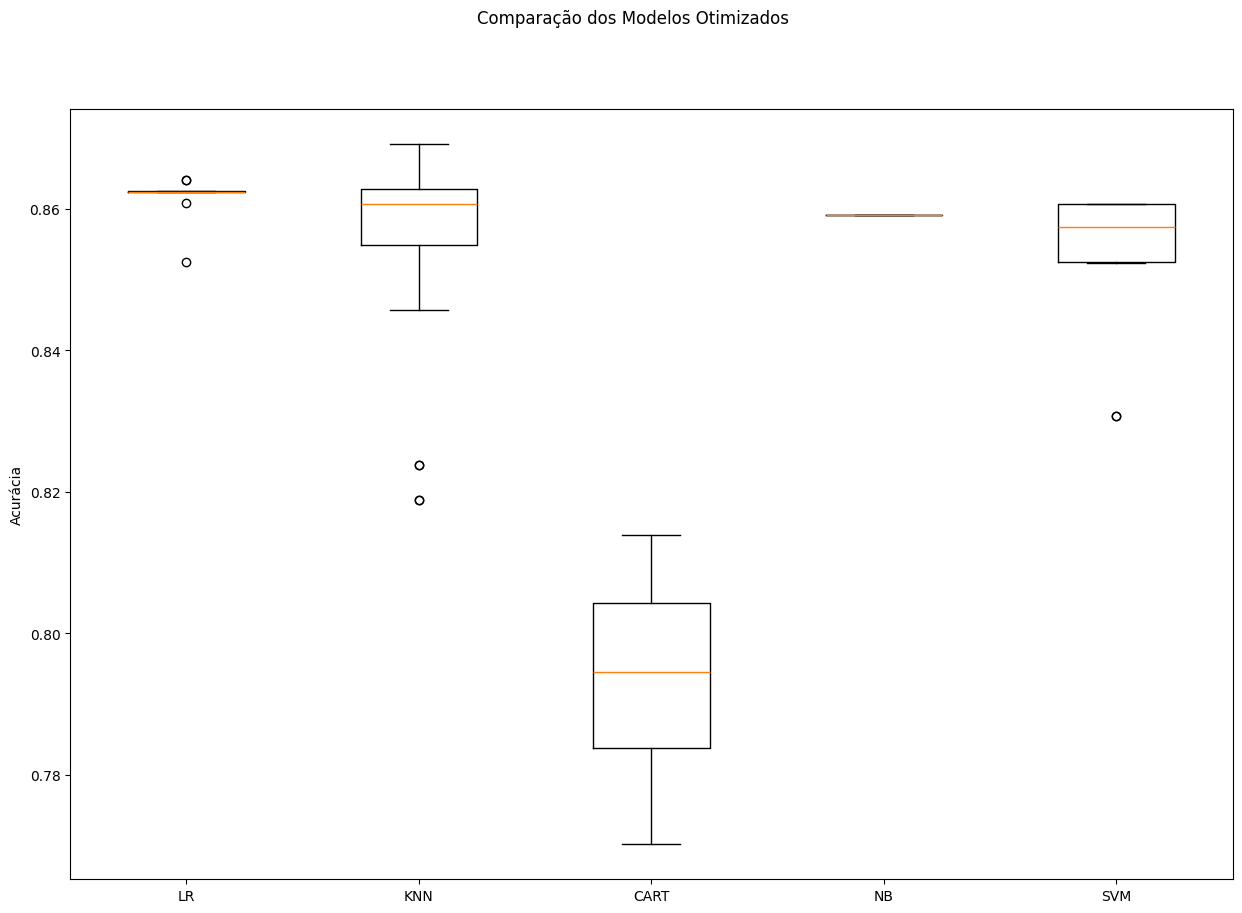

In [ ]:
np.random.seed(7)

# Lista de modelos e suas grades de parâmetros
models = [
    ('LR', LogisticRegression(max_iter=200), {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['lbfgs', 'liblinear']
    }),
    ('KNN', KNeighborsClassifier(), {
        'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan']
    }),
    ('CART', DecisionTreeClassifier(), {
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }),
    ('NB', GaussianNB(), {
        'model__var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
    }),
    ('SVM', SVC(), {
        'model__C': [0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    })
]

# Avaliação e otimização
print("\nResultados da otimização de hiperparâmetros:")
results_opt = []
names_opt = []
best_models = []

for name, model, param_grid in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring, n_jobs=-1)
    grid.fit(X_train, y_train)
    results_opt.append(grid.cv_results_['mean_test_score'])
    names_opt.append(name)
    best_models.append((name, grid.best_estimator_, grid.best_score_, grid.best_params_))
    msg = "%s: Melhor acurácia = %.3f, Parâmetros = %s" % (name, grid.best_score_, grid.best_params_)
    print(msg)

# Adicionar resultados otimizados à comparação geral
for name, best_model, best_score, best_params in best_models:
    all_results.append(best_score)
    all_names.append(f"{name}-otimizado")
    all_pipelines.append(best_model)
    print(f"{name}-otimizado: %.3f" % best_score)

# Boxplot de comparação dos modelos otimizados
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Comparação dos Modelos Otimizados')
ax = fig.add_subplot(111)
plt.boxplot(results_opt)
ax.set_xticklabels(names_opt)
plt.ylabel('Acurácia')
plt.show()

## Selecionar o melhor modelo geral (maior acurácia entre todos os cenários)

In [ ]:
best_index = np.argmax(all_results)
best_model_name = all_names[best_index]
best_model_pipeline = all_pipelines[best_index]
best_accuracy = all_results[best_index]
print(f"\nMelhor modelo geral: {best_model_name} com acurácia de validação {best_accuracy:.3f}")


Melhor modelo geral: KNN-otimizado com acurácia de validação 0.869


## Treinar o melhor modelo com os dados de treino

### Treinar apenas com os dados de treino é mais adequado para avaliação no conjunto de teste, evitando vazamento de dados

In [ ]:
best_model_pipeline.fit(X_train, y_train)

# Avaliação no conjunto de teste
predictions = best_model_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
print(f"\nAvaliação do modelo {best_model_name} no conjunto de teste:")
print(f"\nAcurácia: {test_accuracy:.3f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, predictions))


Avaliação do modelo KNN-otimizado no conjunto de teste:

Acurácia: 0.893

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        78
           1       0.89      0.89      0.89        72

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



## TESTE MODELO

In [ ]:
# Novos dados - não sabemos a classe!
data = {
    'Age': [19, 70, 50],
    'Sex': ['M', 'F', 'M'],
    'ChestPainType': ['ATA', 'NAP', 'ASY'],
    'RestingBP': [110, 100, 130],
    'Cholesterol': [180, 250, 300],
    'FastingBS': [0, 1, 0],
    'RestingECG': ['Normal', 'ST', 'LVH'],
    'MaxHR': [150, 110, 130],
    'ExerciseAngina': ['N', 'Y', 'Y'],
    'Oldpeak': [0, 2, 3.3],
    'ST_Slope': ['Up', 'Flat', 'Down']
}

entrada = pd.DataFrame(data)

# Predição de classes dos dados de entrada com o melhor modelo
saidas = best_model_pipeline.predict(entrada)
print("\nPredições para novos dados com o melhor modelo:", saidas)


Predições para novos dados com o melhor modelo: [0 1 1]


## EXPORTAR MODELO

In [ ]:
# Salvar o melhor modelo em best_model.pkl
with open('BEST_model.pkl', 'wb') as f:
    pickle.dump(best_model_pipeline, f)
print("\nArquivo BEST_model.pkl gerado com sucesso.")


Arquivo BEST_model.pkl gerado com sucesso.


# Análise dos Resultados do Modelo

## Resumo dos Principais Achados:

### Distribuição das Classes:
- Original: 55,34% HeartDisease=1, 44,66% 0 (918 registros).
- Filtrado: 52,28% 0, 47,72% 1 (746 registros após remover 172 com Cholesterol=0 ou RestingBP=0).
- A filtragem reduziu o desbalanceamento, mas a classe 1 ainda é sub-representada.

### Avaliação Inicial:
- LR: Consistente (0,861-0,862).
- KNN: Melhorou com escalonamento (0,660 original → 0,859 padronizado).
- CART: Menor desempenho (0,769-0,775).
- NB: Estável (0,859 em todos os cenários).
- SVM: Forte com escalonamento (0,680 original → 0,864 normalizado).

## Otimização:
- KNN-otimizado: Melhor acurácia (0,869, n_neighbors=11, manhattan, distance).
- LR-otimizado: 0,864 (C=10, lbfgs)
- SVM-otimizado: 0,861 (C=1, kernel=linear).
- CART-otimizado: 0,814 (menor desempenho).
- NB-otimizado: 0,859 (estável).

## Pontos de Atenção:
- Desbalanceamento: Pode impactar o recall da classe 1. Poderia ainda ser usado o SMOTE para balancear as classes.
- Métricas: Fui utilizada a acurácia para escolha do melhor modelo, mas para exames médis poderiam ser usados como referência outros métricas mais indicadas como F1-score e recall.

## Conclusão
O modelo KNN otimizado, com acurácia de validação de 0,869, foi selecionado como o melhor, beneficiado pelo escalonamento (StandardScaler) e hiperparâmetros ajustados (n_neighbors=11, metric='manhattan', weights='distance'). A filtragem de outliers (Cholesterol=0, RestingBP=0) melhorou a qualidade dos dados, mas ainda apresentou um leve desbalanceamento, que pode ser mitigado com técnicas como SMOTE.